In [ ]:
# GOAL : What am I searching for ?
        # => To predict with the best possible accuracy (proba) an event (+/- xx% variation of close_price)
        # What for ?
            # => To be able to balance my portfolio (sell what should go down for what should go up)
            # => Sell crypto for Stable coin / Or buy crypto with Stable Coin
########

In [ ]:
# Advices : 
    # Be careful to scaling, min / max can change in the future...

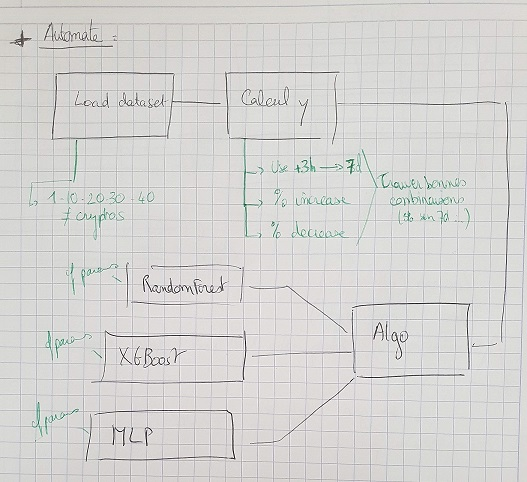

In [34]:
from IPython.display import Image
Image(filename='Schema.jpg')

In [ ]:
# DONE Now
    # 1 / Industrialization : 
        # Dataset for TOP 20 cryptos + capacity to learn from top 20 and predict 1 : DONE !
    # 2 / Gérer le fait qu'on a des datasets déséquilibrés ? : OK
    # 3 / Gérer l'overfitting de ouf : OK

In [ ]:
# TODO Now :
    # 4 / Faire du gridsearch puis optimiser avec treshold - Lister tout ce que je veux tester :
        # Apprentissage avec dataset 1-10-20-30-40 cryptos
        # Focus sur algo : XGBoost, RandomForest, MLP
        # Différents y +3h, +6h, +12h, +24h, +36h etc.
        # Différents %increase / decrease
        
        # Différents paramètres des algo avec Gridsearch (optimiser precision) - différents selon algos
            # => RandomForest bien foutu :
                # https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
            # => Tous les exemples : https://www.programcreek.com/python/example/91151/sklearn.model_selection.GridSearchCV        
        # Show learning curve ? Precision / Recall curve Other metrics ? Jouer sur Treshold pour maximiser précision
        # Rapport Global qui met en avant les meilleurs modèles et les paramètres qui ont permis de les obtenir !
    
    # 5 / Construire algo de strategy backtest Buy / Sell + indicateur de stratégie (prendre en compte prévisions d'augmentation et prévisions de baisse)  
    
    # 6 / Une fois que j'ai fait tout ça :
        # lecture + recherche internet d'inspiration / travaux semblables 
        # Feature engineering : 
            # New :
                # Variance close price, volumes 3h, 6h, 12h, 24h, etc., more indicators on different scale
                # Mean 24h price
                # Mean 24h price - current price
            # Delete useless ? Do real feature engineering with data vizualisation, correlation, etc.
    
    # 7 / Others :
        # Serialize scikit learn model: http://scikit-learn.org/stable/modules/model_persistence.html
        # Use cross validation ?
        # Différents algo de scaling en preprocessing
        # Mieux comprendre ce qui est fait par l'algo, ex Randomforest, afficher arbre avec seuils, etc.
        
    # 8 / A terme je pourrais avoir :
        # Des modèles qui se mettent à jour automatiquement
        # Pleins de modèles utilisés à différentes échelles pour savoir si il faut vendre ou acheter ! 
            # cf. que faire en fonction des différentes probas
    

In [ ]:
# TODO Global : 
    # 0 / Read : What is being done elsewhere, feature enginerring, algo, etc.
    # 1 / Testing phase + take ownership of the code
        # 1.1 / Test y_value and y_classif to be sure it's well calculated
        # 1.2 / Understand well what the code is doing end-to-end
    # 2 / Data vizualisation : Re-read MOOC + articles, what can I do ? Correlations, etc. => Visiblement aime bien les booleans !
    # 3 / Choose features + add with features engineering if needed
        # 3.1 / Other indicators - 10d-20d-30d, etc. ?
        # 3.2 / Add info about trend 1h, 12h, 24h, 3d, 7d, 15d, 30d, etc. ?
        # 3.3 / Volume indicators
    # 4 / Create an automate that can :
        # 4.1 / Test different y, different % increase / deacrease, different algo
        # 4.2 / Try predicting the next hour / next 3h !!! It's stupid to predict +12h whereas I'll have more accurate data after that...
        # 4.3 / Do Gridsearch or other kind of search to find good parameters
        # 4.4 / Export results in a way that they are easy to choose    
    # 5 / Try value instead of classif ?
    # 6 / Try to learn with multiple dataset of different crypto ?
    # 7 / Validation : Find ways to validate models, treshold, proba, etc.
    # 8 / Do TA on bitcoin also when included in crypto dataset
    
    # Try to optimize each algo at a time, see if I can use other algo 
    
# https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05

In [1]:
from utils_csa import show_model_accuracy

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split

# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc

#np.set_printoptions(threshold='nan')

importing Jupyter notebook from algocryptos_preprocessing.ipynb


In [2]:
# ------------------ PARAMETERS ------------------ #

# Choose y to be considered
# ['y_+3h_value', 'y_+3h_classif',, 'y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif',
#       'y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif',
#       'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif',
#       'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "7605" # ether 7605
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
dict_hours_labels  = {3:'3h', 6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}

In [3]:
# ------------------ DATA VIZUALISATION ------------------ #

# correlations (to be done with y to be searched, here not interesting...)
#print(df.close_price.corr(df.reddit_subscribers))
#print(df.close_price.corr(df.reddit_subscribers_slope))
#print(df.close_price.corr(df.volume_aggregated))
#print(df.close_price.corr(df.volume_aggregated_slope))

In [23]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #

# Take one crypto only
#df = alg_preproc.get_global_dataset_for_crypto("236131")
#df2 = df.reset_index(drop=True)
#df2 = df[['open_price', 'high_price', 'low_price', 'close_price','Indic_OBV_uptrend_15d', 'Indic_RSI_14d_uptrend', 'reddit_subscribers_pct_change_7d', 'Indic_RSI_14d_uptrend', 'Indic_EMA_15d_uptrend', 'Indic_EMA_7d_uptrend', 'Indic_Bbands_20d_diff_close_lowerband', 'close_price_variance_15d_tether', 'close_price_pct_change_vs_7d_high', 'volume_aggregated_24h', 'close_price_variance_30d_bitcoin']]

# Take first 20 cryptos
dict_df = alg_preproc.get_global_datasets_for_top_n_cryptos(40)

#df_tp = df2.iloc[:,0:123]
#df_tp.reddit_subscribers_pct_change_1d.sort_values()
#tmp = scaler.fit_transform(df_tp)
#df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(how="all")

#del dict_df["236131"]

#df_global.info(memory_usage='deep')

Crypto : 5280

Crypto : 16713

Crypto : 20333

Crypto : 41192

7713rows containing Nan dropped

Crypto : 166390

Crypto : 1182

Crypto : 172091

750rows containing Nan dropped

Crypto : 4430

Crypto : 409492



C:\Users\cysac\Anaconda3\lib\site-packages\scipy\stats\stats.py:2242: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Crypto : 5031

Crypto : 7605

Crypto : 5039

Crypto : 202330

Crypto : 166503

Crypto : 13072

Crypto : 4614

Crypto : 3808

Crypto : 171986

Crypto : 321992

Crypto : 204788

Crypto : 5038

Crypto : 310829

Crypto : 3807

Crypto : 236131

754rows containing Nan dropped

Crypto : 27368

Crypto : 5324

Crypto : 186277

Crypto : 5285

Crypto : 24854

Crypto : 4432

Crypto : 187440

Crypto : 347235

Crypto : 716725



C:\Users\cysac\Anaconda3\lib\site-packages\scipy\stats\stats.py:2248: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\cysac\PycharmProjects\algocryptos_scripts\notebooks\ML\utils_csa.py:74: RuntimeWarning: invalid value encountered in less
  df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)]


750rows containing Nan dropped

Crypto : 808414

754rows containing Nan dropped

Crypto : 112392

7750rows containing Nan dropped

Crypto : 190978

Crypto : 19745

Crypto : 107672

Crypto : 324068

Crypto : 127356



In [25]:
# ------------------ PRE-PROCESSING : Calcul y + split data ------------------ #
columns_nb = 0
df_new_dict = {}
df_new_list = []

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

def do_split_data(df_p, columns_nb_p):
    # separe x,y
    X = df_p.iloc[:,range(1, columns_nb_p)]
    y = df_p.iloc[:,range(columns_nb_p, len(df_p.columns))]

    # split data in training / validating / testing
    return train_test_split(X, y, random_state=0, shuffle=False)

# calcul y for each crypto
for key_id_cryptocompare, df_one_crypto in dict_df.items():
    # number of columns before adding y values - could be done once only
    columns_nb = len(df_one_crypto.columns)

    # calcul all y values we are interested in and add it to the dataframe
    df_one_crypto = calcul_values_of_y(df_one_crypto.copy(), dict_hours_labels, close_price_increase_targeted)

    # remove rows where y can't be calculed (need more data in the future)
    df_one_crypto.dropna(subset=list(df_one_crypto.iloc[:,range(columns_nb, len(df_one_crypto.columns))]), inplace=True)
    
    df_new_dict[key_id_cryptocompare] = df_one_crypto
    df_new_list.append(df_one_crypto)

# concat to get only one dataframe instead of a list of dataframes
df_global = pd.concat(df_new_list).sort_index()
#df_global.reset_index(drop=True)

# All cryptos
X_train, X_test, y_train, y_test = do_split_data(df_global, columns_nb)

# The one to predict
X_train_one_crypto, X_test_one_crypto, y_train_one_crypto, y_test_one_crypto = do_split_data(df_new_dict[id_cryptocompare], columns_nb)
X_test = X_test_one_crypto
y_test = y_test_one_crypto

# TODO : To be used to avoid overitting : No tuning while using testing data, only validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[113892  33105]
 [ 11501  32790]]
Accuracy: 0.77
AUC: 0.76


Other Metrics :

             precision    recall  f1-score   support

      False       0.91      0.77      0.84    146997
       True       0.50      0.74      0.60     44291

avg / total       0.81      0.77      0.78    191288

----------------------------------------------------------



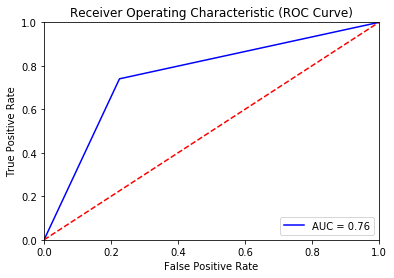

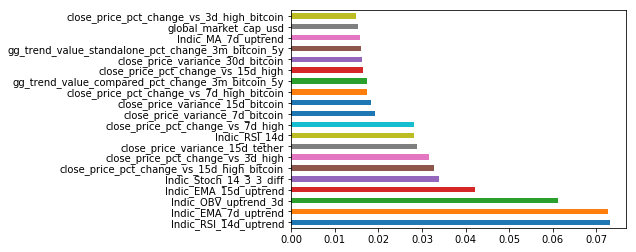

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1374  197]
 [  45  142]]
Accuracy: 0.86
AUC: 0.82


Other Metrics :

             precision    recall  f1-score   support

      False       0.97      0.87      0.92      1571
       True       0.42      0.76      0.54       187

avg / total       0.91      0.86      0.88      1758

----------------------------------------------------------



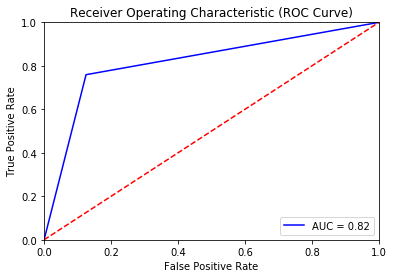

[0.24273989 0.24273989 0.24273989 ... 0.73919356 0.74300915 0.74366954]


In [26]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, max_features='auto', max_depth=5, criterion='entropy', class_weight="balanced").fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=True)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

# proba : to be shown by prediction, bien comprendre !
probas = clf.predict_proba(X_test_scaled)[:,1]
#print(probas)
print(np.sort(probas))

# clf.decision_path(X_test)

In [14]:
# search for correlations
#for col in df3.columns.values:
#    if df3[col].corr(df3['y_+1d_classif']) > 0.2:
#        print(col + ' - ' + str(df3[col].corr(df3['y_+1d_classif'])))

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Train
----------------------------------------------------------

Confusion Matrix :
 [[77128  3956]
 [ 6557 14469]]
Accuracy: 0.90
AUC: 0.82


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.95      0.94     81084
       True       0.79      0.69      0.73     21026

avg / total       0.89      0.90      0.89    102110

----------------------------------------------------------



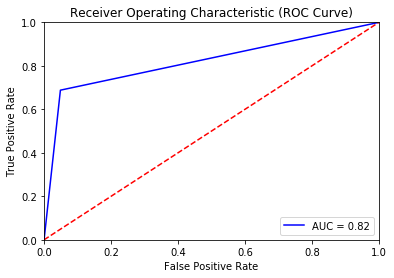

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Test
----------------------------------------------------------

Confusion Matrix :
 [[1476   94]
 [  69  118]]
Accuracy: 0.91
AUC: 0.79


Other Metrics :

             precision    recall  f1-score   support

      False       0.96      0.94      0.95      1570
       True       0.56      0.63      0.59       187

avg / total       0.91      0.91      0.91      1757

----------------------------------------------------------



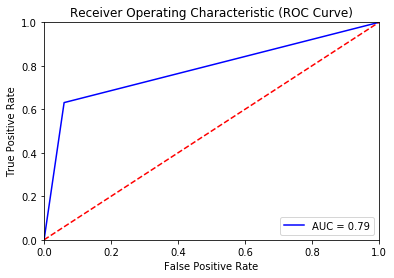

In [7]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

# proba : to be shown by prediction, bien comprendre !
#print(pd.DataFrame(nnclf.predict_proba(X_test_scaled)[:,1]))

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[79039  2045]
 [10721 10305]]
Accuracy: 0.87
AUC: 0.73


Other Metrics :

             precision    recall  f1-score   support

      False       0.88      0.97      0.93     81084
       True       0.83      0.49      0.62     21026

avg / total       0.87      0.87      0.86    102110

----------------------------------------------------------



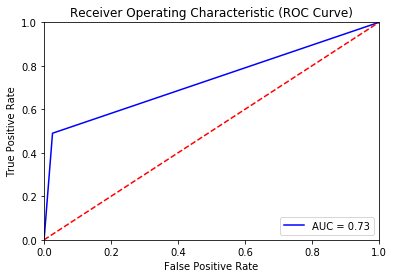

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1517   53]
 [ 125   62]]
Accuracy: 0.90
AUC: 0.65


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.97      0.94      1570
       True       0.54      0.33      0.41       187

avg / total       0.88      0.90      0.89      1757

----------------------------------------------------------



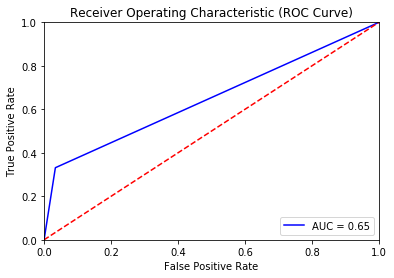

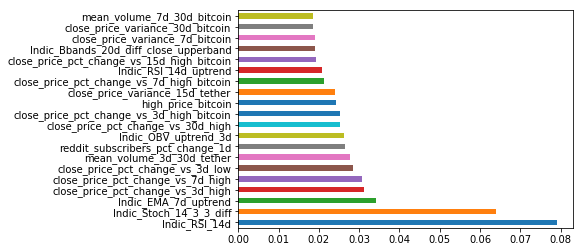

In [10]:
# -----------------------
# ALGO : GradientBoostingClassifier (cf. Module+4 for tuning)
# -----------------------
from sklearn.ensemble import GradientBoostingClassifier

#GradientBoostingClassifier(learning_rate = 0.02, max_depth = 5, random_state = 0)
clf = GradientBoostingClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('GradientBoostingClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('GradientBoostingClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)

----------------------------------------------------------
Results for algorithm : SVM - Train
----------------------------------------------------------

Confusion Matrix :
 [[3778  118]
 [ 275  690]]
Accuracy: 0.92
AUC: 0.84


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.97      0.95      3896
       True       0.85      0.72      0.78       965

avg / total       0.92      0.92      0.92      4861

----------------------------------------------------------



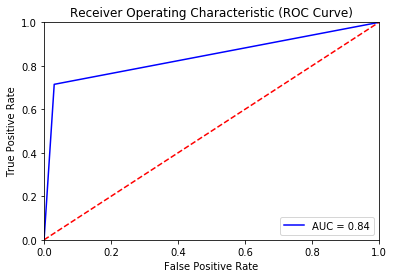

----------------------------------------------------------
Results for algorithm : SVM - Test
----------------------------------------------------------

Confusion Matrix :
 [[1293  190]
 [  99   39]]
Accuracy: 0.82
AUC: 0.58


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.87      0.90      1483
       True       0.17      0.28      0.21       138

avg / total       0.86      0.82      0.84      1621

----------------------------------------------------------



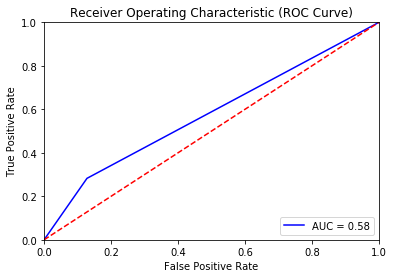

In [31]:
# -----------------------
# ALGO : SVC - (cf. Module+3 for tuning)
# -----------------------
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1).fit(X_train_scaled, y_train[y_to_be_considered])


show_model_accuracy('SVM - Train', svm, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('SVM - Test', svm, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

In [49]:
import seaborn
c = X_train.corr()
#plt.figure(figsize=(10,10))
#seaborn.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) <= 0.8))
#plt.show()

In [ ]:
# RandomizedSearchCV
from sklearn.grid_search import RandomizedSearchCV
params = {"n_neighbors": range(1,5), "weights": ["uniform", "distance"]}
rsearch = RandomizedSearchCV(estimator=knn,
param_distributions=params,
cv=4,
n_iter=8,
random_state=5)
rsearch.fit(X_train, y_train)
print(rsearch.best_score_)

In [8]:
# ------------------ MODEL FITTING ------------------ #

# -----------------------
# ALGO : DUMMY CLASSIFIER
# -----------------------
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('DummyClassifier - Train', dummy_clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns)
show_model_accuracy('DummyClassifier - Test', dummy_clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns)

----------------------------------------------------------
Results for algorithm : DummyClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[81084     0]
 [21026     0]]
Accuracy: 0.79
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.79      1.00      0.89     81084
       True       0.00      0.00      0.00     21026

avg / total       0.63      0.79      0.70    102110

----------------------------------------------------------

----------------------------------------------------------
Results for algorithm : DummyClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1570    0]
 [ 187    0]]
Accuracy: 0.89
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.89      1.00      0.94      1570
       True       0.00      0.00      0.00       187

avg / total       0.80      0.89      0.84   

C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Train
----------------------------------------------------------

Confusion Matrix :
 [[64590 16494]
 [ 4767 16259]]
Accuracy: 0.79
AUC: 0.78


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.80      0.86     81084
       True       0.50      0.77      0.60     21026

avg / total       0.84      0.79      0.81    102110

----------------------------------------------------------



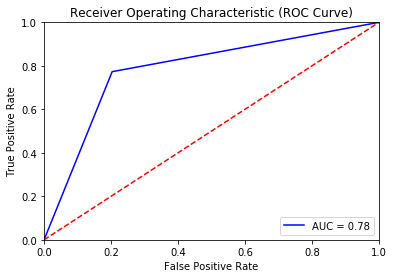

----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Test
----------------------------------------------------------

Confusion Matrix :
 [[1466  104]
 [  52  135]]
Accuracy: 0.91
AUC: 0.83


Other Metrics :

             precision    recall  f1-score   support

      False       0.97      0.93      0.95      1570
       True       0.56      0.72      0.63       187

avg / total       0.92      0.91      0.92      1757

----------------------------------------------------------



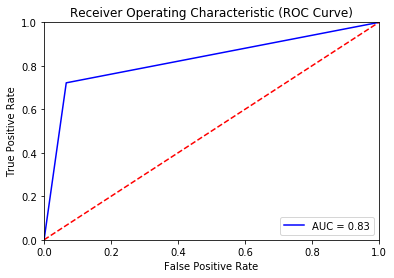

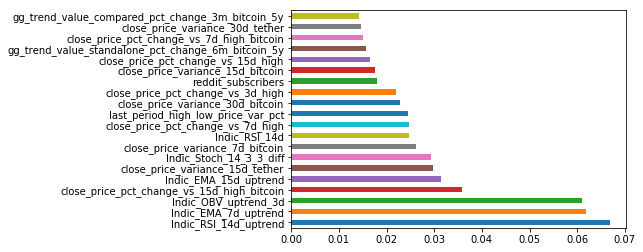

In [9]:
# -----------------------
# ALGO : NAIVE BAYES - GAUSSIANNB
# -----------------------
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('NAIVE BAYES - GaussianNB - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('NAIVE BAYES - GaussianNB - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)
